# Generating features with PCA (string patterns of length 16)

In this notebook we overview the [Genetic Engineering Attribution competition in Driven Data](https://www.drivendata.org/competitions/63/genetic-engineering-attribution/).   

In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import requests
from tqdm import tqdm
from collections import OrderedDict, defaultdict, Counter
import seaborn as sns
import json
from sklearn.decomposition import PCA
#from joblib import dump, load
import joblib

CPU times: user 588 ms, sys: 48.3 ms, total: 636 ms
Wall time: 844 ms


## Loading data

In [2]:
#parent_dir = "/content/genetic_engineering_attribution"
parent_dir = "/home/rio/data_sets/genetic_engineering_attribution"

#### Data

In [4]:
%%time
### pca directory
pca_dir = os.path.join(parent_dir,"pca")

### train/val/test directories
full_train_dir = os.path.join(parent_dir,"full_train") 
train_dir = os.path.join(parent_dir,"train") 
val_dir = os.path.join(parent_dir,"val")
test_dir = os.path.join(parent_dir,"test")

### Paths to csvs
full_train_path = os.path.join(full_train_dir,"full_train.csv")
train_path = os.path.join(train_dir,"train.csv")
val_path = os.path.join(val_dir,"val.csv")
test_path = os.path.join(test_dir,"test.csv")

### Dataframes
df_full_train = pd.read_csv(full_train_path,index_col=0)
df_train = pd.read_csv(train_path,index_col=0)
df_val = pd.read_csv(val_path,index_col=0)
df_test = pd.read_csv(test_path,index_col=0)

### Printing shapes:
print(f"Shape of df_full_train: {df_full_train.shape}")
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_full_train: (63017, 43)
Shape of df_train: (50413, 43)
Shape of df_val: (12604, 43)
Shape of df_test: (18816, 43)
CPU times: user 3.68 s, sys: 348 ms, total: 4.02 s
Wall time: 4.02 s


In [5]:
df_full_train.head()

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
0,9ZIMC,RYUA3GVO,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,7151,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5SAQC,RYUA3GVO,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,456,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E7QRO,RYUA3GVO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1450,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CT5FP,RYUA3GVO,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,914,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7PTD8,RYUA3GVO,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1350,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### String patterns

In [6]:
%%time
### directory of string patterns
string_patterns_dir = os.path.join(parent_dir,"string_patterns")

### string patterns jsons
string_patterns_04 = os.path.join(string_patterns_dir,"string_patterns_04.json")
string_patterns_08 = os.path.join(string_patterns_dir,"string_patterns_08.json")
string_patterns_16 = os.path.join(string_patterns_dir,"string_patterns_16.json")
string_patterns_32 = os.path.join(string_patterns_dir,"string_patterns_32.json")
string_patterns_64 = os.path.join(string_patterns_dir,"string_patterns_64.json")

### choose string pattern
string_patterns_file = string_patterns_16
### loading string pattern
with open(string_patterns_file) as json_file:
    string_patterns = json.load(json_file)
print("Length of string_patterns_16: ", len(string_patterns))


Length of string_patterns_16:  3486651
CPU times: user 1.68 s, sys: 252 ms, total: 1.93 s
Wall time: 1.93 s


In [7]:
%%time
string_patterns

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.25 µs


{'CATGCATTAGTTATTA': 180,
 'ATAGTAATCAATTACG': 448,
 'GGGTCATTAGTTCATA': 446,
 'GCCCATATATGGAGTT': 436,
 'CCGCGTTACATAACTT': 437,
 'ACGGTAAATGGCCCGC': 1134,
 'CTGGCTGACCGCCCAA': 470,
 'CGACCCCCGCCCATTG': 464,
 'ACGTCAATAATGACGT': 479,
 'ATGTTCCCATAGTAAC': 480,
 'GCCAATAGGGACTTTC': 487,
 'CATTGACGTCAATGGG': 2492,
 'TGGAGTATTTACGGTA': 469,
 'AACTGCCCACTTGGCA': 487,
 'GTACATCAAGTGTATC': 486,
 'ATATGCCAAGTACGCC': 527,
 'CCCTATTGACGTCAAT': 589,
 'GACGGTAAATGGCCCG': 575,
 'CCTGGCATTATGCCCA': 573,
 'GTACATGACCTTATGG': 533,
 'GACTTTCCTACTTGGC': 582,
 'AGTACATCTACGTATT': 576,
 'AGTCATCGCTATTACC': 576,
 'ATGGTGATGCGGTTTT': 463,
 'GGCAGTACATCAATGG': 449,
 'GCGTGGATAGCGGTTT': 476,
 'GACTCACGGGGATTTC': 466,
 'CAAGTCTCCACCCCAT': 464,
 'TGACGTCAATGGGAGT': 466,
 'TTGTTTTGGCACCAAA': 459,
 'ATCAACGGGACTTTCC': 461,
 'AAAATGTCGTAACAAC': 414,
 'TCCGCCCCATTGACGC': 416,
 'AAATGGGCGGTAGGCG': 483,
 'TGTACGGTGGGAGGTC': 469,
 'TATATAAGCAGAGCTG': 266,
 'GTTTAGTGAACCGTCA': 416,
 'GATCCGCTAGCGCTAC': 167,
 'CGGTCGCC

## Mapping string patterns to vectors

In [8]:
def str2vec(sequence,keywords={"A":[1,0,0,0,0], "T":[0,1,0,0,0], "G":[0,0,1,0,0], "C":[0,0,0,1,0], "N":[0,0,0,0,1]}):
    vec = []
    for s in sequence:
        vec.extend(keywords[s])
    return np.array(vec)

def str2mat(sequences,keywords={"A":[1,0,0,0,0], "T":[0,1,0,0,0], "G":[0,0,1,0,0], "C":[0,0,0,1,0], "N":[0,0,0,0,1]}):
    mat = np.array([str2vec(seq) for seq in tqdm(sequences)])
    return mat

## Fitting PCA 

#### Getting string patterns

In [9]:
%%time
mat = str2mat(string_patterns.keys())
print("Shape of mat: ", mat.shape)

100%|██████████| 3486651/3486651 [00:21<00:00, 158858.94it/s]


Shape of mat:  (3486651, 80)
CPU times: user 22.8 s, sys: 1.73 s, total: 24.5 s
Wall time: 24.5 s


In [10]:
list(string_patterns.keys())[35261]

'CGATTCATGGTTTATA'

In [11]:
mat[35261,:]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

## Fitting PCA

In [12]:
%%time
n_components=None
pca = PCA(n_components)
pca.fit(mat)

CPU times: user 29.8 s, sys: 4.12 s, total: 33.9 s
Wall time: 15.2 s


PCA()

Text(0.5, 1.0, 'Explained variance')

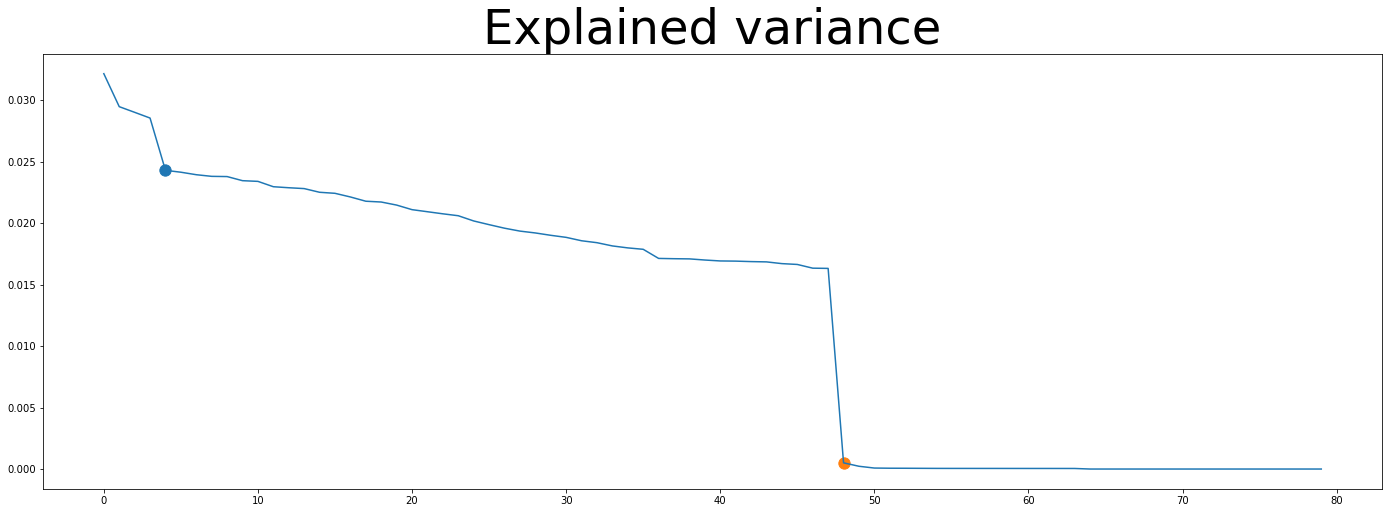

In [28]:
explained_variance = pca.explained_variance_ratio_
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(explained_variance)
### elbow 
elbow = 4
ax.scatter(elbow,explained_variance[elbow],s=128)
## knee
knee = 48
ax.scatter(knee,explained_variance[knee],s=128)
ax.set_title("Explained variance", fontsize=48)

In [29]:
explained_variance

array([3.21403270e-02, 2.94594159e-02, 2.89993229e-02, 2.85332737e-02,
       2.42827680e-02, 2.41304077e-02, 2.39272749e-02, 2.37944234e-02,
       2.37762500e-02, 2.34420383e-02, 2.33855932e-02, 2.29509977e-02,
       2.28683289e-02, 2.27991062e-02, 2.24991554e-02, 2.24150649e-02,
       2.21177945e-02, 2.17717977e-02, 2.17072988e-02, 2.14584453e-02,
       2.10866091e-02, 2.09177472e-02, 2.07483257e-02, 2.05924193e-02,
       2.01677226e-02, 1.98670652e-02, 1.95793133e-02, 1.93431985e-02,
       1.91927563e-02, 1.90013372e-02, 1.88341672e-02, 1.85577433e-02,
       1.84005808e-02, 1.81377538e-02, 1.79781042e-02, 1.78632943e-02,
       1.71223296e-02, 1.70989127e-02, 1.70841100e-02, 1.69915514e-02,
       1.69162523e-02, 1.69025048e-02, 1.68637631e-02, 1.68402842e-02,
       1.66992871e-02, 1.66318219e-02, 1.63292971e-02, 1.63111083e-02,
       5.04602663e-04, 2.24762656e-04, 8.00054584e-05, 6.57819243e-05,
       6.31196060e-05, 5.76034250e-05, 5.22958666e-05, 5.05834230e-05,
      

In [34]:
knee

48

In [30]:
explained_variance[48]

0.0005046026633820292

In [32]:
len(explained_variance[:knee])

48

In [33]:
explained_variance[:knee]

array([0.03214033, 0.02945942, 0.02899932, 0.02853327, 0.02428277,
       0.02413041, 0.02392727, 0.02379442, 0.02377625, 0.02344204,
       0.02338559, 0.022951  , 0.02286833, 0.02279911, 0.02249916,
       0.02241506, 0.02211779, 0.0217718 , 0.0217073 , 0.02145845,
       0.02108661, 0.02091775, 0.02074833, 0.02059242, 0.02016772,
       0.01986707, 0.01957931, 0.0193432 , 0.01919276, 0.01900134,
       0.01883417, 0.01855774, 0.01840058, 0.01813775, 0.0179781 ,
       0.01786329, 0.01712233, 0.01709891, 0.01708411, 0.01699155,
       0.01691625, 0.0169025 , 0.01686376, 0.01684028, 0.01669929,
       0.01663182, 0.0163293 , 0.01631111])

## Fitting and saving PCA

In [35]:
%%time
n_components=knee
pca = PCA(n_components)
pca.fit(mat)
### saving
filename = f"pca_16_{knee}comp.joblib"
savepath = os.path.join(pca_dir,filename)
joblib.dump(pca,savepath)

CPU times: user 1min 4s, sys: 5.47 s, total: 1min 9s
Wall time: 27.8 s


['/home/rio/data_sets/genetic_engineering_attribution/pca/pca_16_48comp.joblib']

In [36]:
%%time
mat_transform = pca.transform(mat)
mat_transform.shape

CPU times: user 1.13 s, sys: 260 ms, total: 1.39 s
Wall time: 780 ms


(3486651, 48)